<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/master/DCGAN_MNIST/dcgan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Mar 16 16:38:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Using Keras Sequential API with tf.GradientTape for training
#### src : https://www.tensorflow.org/tutorials/generative/dcgan

### Steps 
- Generator (Creates images that looks real)
- Discriminator (Distinguishes b/w real and fake images)

### Process
- Keep improving the Generator till the Discriminator is not able to distinguish between them (equilibrium).
- Each step will improve both Generator and Discriminator.

#### Let's start Coding.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [4]:
tf.compat.v1.enable_eager_execution()

#### To Generate GIFs

In [5]:
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 7.3MB/s 


In [29]:
import glob
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import os
import time
import PIL
from IPython import display
from numba import cuda
from tqdm import tqdm

%matplotlib inline

tf.keras.backend.clear_session()

#### Load and Prepare Dataset

In [7]:
(train_images,train_labels),(_,_) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [9]:
BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 64

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

### Model Creation

#### Generator Model

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides = (2,2), padding = 'same' , use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

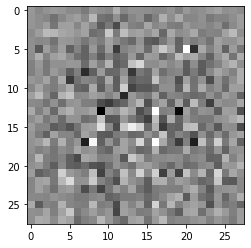

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

### Making the Discriminator

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same', input_shape = [28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,(5,5),strides = (2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00077463]], dtype=float32)>

#### Defining Loss and Optimizers

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

##### Discriminator Loss

In [20]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

##### Generator Loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

##### Optimizers

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Saving Checkpoints

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

#### Training

In [24]:
EPOCHS = 50
noise_dim = 100
num_ex_to_generate = 16
seed = tf.random.normal([num_ex_to_generate,noise_dim])

In [25]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [26]:
def generate_and_save_images(model,epoch, test_input):
    predictions = model(test_input,training=False)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5 + 127.5,cmap='gray')
        plt.axis('off')
        
    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.show()

In [32]:
def train(dataset,epochs):
    for epoch in tqdm(range(epochs),position=0, leave=True):
        start = time.time()
        
        for image_batch in tqdm(dataset,position=0, leave=True):
            train_step(image_batch)
            
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

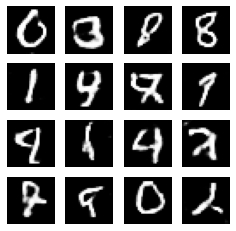

In [33]:
train(train_dataset,EPOCHS)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [41]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:02d}.png'.format(epoch_no))

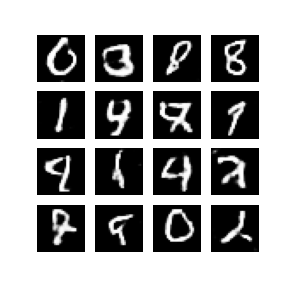

In [42]:
display_image(EPOCHS)

In [43]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


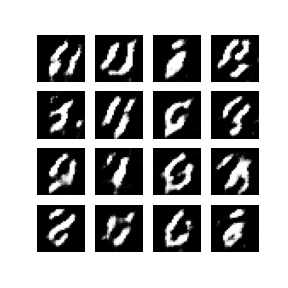

In [44]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
!cp -R /content/training_checkpoints /content/drive/MyDrive/Github/DCGAN_images_model

In [ ]:
!cp -R /content/*.png /content/drive/MyDrive/Github/DCGAN_images_model/images

In [45]:
!cp /content/*.gif /content/drive/MyDrive/Github/DCGAN_images_model/images